## Demo - Types of noise

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import cv2

Read RGB image

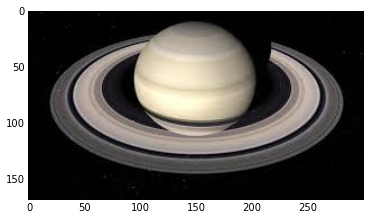

In [2]:
RGB = mpimg.imread('images/saturn.jpg')
imgplt = plt.imshow(RGB)

Convert to gray scale

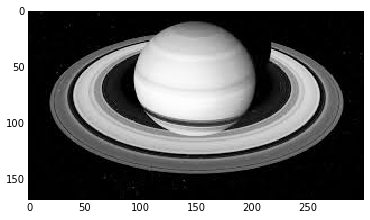

In [3]:
I = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY)
imgplt = plt.imshow(I, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

Add Gaussian noise with variance of 0.1 (because 0.02 doesn't show much visible distortion)

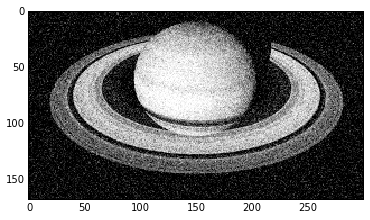

In [4]:
# variance = 0.02 * 255  # variance of 0.02
variance = 0.1 * 255  # variance of 0.1

I2G = np.clip(I + np.random.normal(0, variance, I.shape).astype(np.int), 0, 255) # variance of 0.1
imgplt = plt.imshow(I2G, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

Write salt & pepper noise function since none is available in numpy
- Try this http://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise

In [5]:
def salt_pepper(img, r=0.1, sp_ratio=0.5):
    '''
    Function to add random salt & pepper noise
    r: noise percentage
    sp_ratio: salt to pepper ratio
    '''
    
    # Image dimensions
    height, width = img.shape[:2]
    n = np.prod(img.shape[:2])

    m = int(r * n)             # number of noisy pixels
    s = int(sp_ratio * m)     # number of salt pixels

    # get m random coordinates
    img_noisy = np.copy(img)
    for y, x in zip(np.random.randint(0, height, s), np.random.randint(0, width, s)):
        img_noisy[y, x] = 255
    for y, x in zip(np.random.randint(0, height, m - s), np.random.randint(0, width, m - s)):
        img_noisy[y, x] = 0
    return img_noisy

Add 2% salt & pepper noise

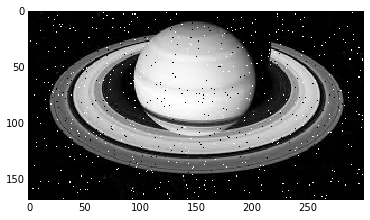

In [6]:
I2 = salt_pepper(I, 0.02)
imgplt = plt.imshow(I2, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

Add 20% salt & pepper noise

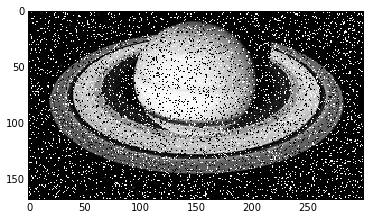

In [7]:
I20 = salt_pepper(I, 0.2)
imgplt = plt.imshow(I20, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

##Gaussian blur

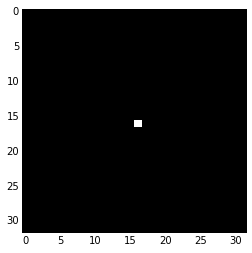

In [8]:
# Create image with Delta function
A = np.zeros((32,32), dtype=np.uint8)
A[16,16] = 255

imgplt = plt.imshow(A, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

###5x5 kernel and sigma=3
OpenCV: http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#gaussianblur

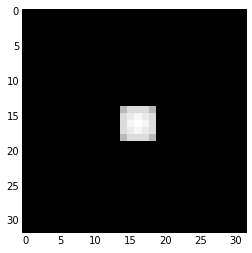

In [9]:
# Kernel spec
k = 5
sigma = 3

B0 = cv2.GaussianBlur(A, ksize=(k, k), sigmaX=sigma)

#imgplt = plt.imshow(blur, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
imgplt = plt.imshow(B0, cmap=cm.Greys_r, interpolation="nearest")

SciPy: http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.gaussian_filter.html

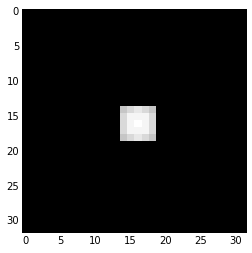

In [10]:
from scipy.ndimage import filters as fltrs

t = float(k//2)/sigma
B1 = fltrs.gaussian_filter(A, sigma=sigma, truncate=t)

imgplt = plt.imshow(B1, cmap=cm.Greys_r, interpolation="nearest")

Compare the 2 Gaussian blur filters with PSNR

In [11]:
# PSNR for image quality comparison
def psnr(i0, i1):
    mse = np.mean(np.square(i0 - i1))
    if mse == 0:  # prevent errors with log(0)
        mse = np.finfo(float).eps
    return np.round(20 * np.log10(255) - 10*np.log10(mse), 2)

In [12]:
print(psnr(B0, B1))

66.47


Histogram  

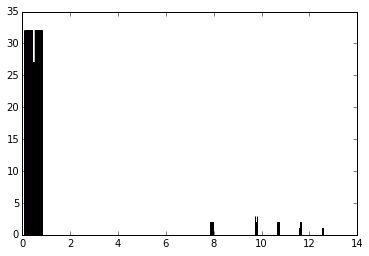

In [13]:
hplt = plt.hist(B0, bins=1+np.max(B0), range=(0, np.max(B0)))

#hist, bins = np.histogram(B0, bins=1+np.max(B0), range=(0, np.max(B0)), density=True)
#imgplt = plt.plot(bins[:-1], hist)

##Modelling motion blur
Approach:
- Create filter kernel
- Apply cv2.filter2D() http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#filter2d

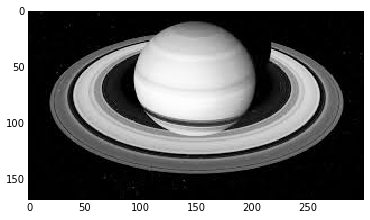

In [14]:
# Saturn
imgplt = plt.imshow(I, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

In [15]:
# generating the kernel
def motion_kernel(k):
    kernel = np.zeros((k, k))
    # kernel[k//2, :] = np.ones(k) # horizontal movement
    # kernel = np.ones((k, k))

    np.fill_diagonal(kernel, 1) # diagonal movement
    # kernel = kernel[::-1] # flip axis

    kernel /= kernel.sum()
    return kernel

In [16]:
# Add noise
def add_noise(i, sigma):
    return np.clip(i + np.random.normal(0, sigma, i.shape).astype(np.int), 0, 255).astype(np.uint8)

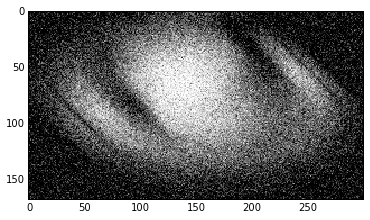

In [17]:
# applying the kernel to the input image
k = 49 
m = cv2.filter2D(I, -1, motion_kernel(k))

# Add noise
variance = 0.15 * 255 
g = add_noise(m, variance) # variance of 0.1

imgplt = plt.imshow(g, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")


##Fun with Wiener filtering
Create Wiener filter based on motion blur filter

Use original Lena

In [18]:
from numpy.fft import fft2
from numpy.fft import ifft2

# Lena original 512x512
img = cv2.imread('images/4.2.04.tiff', cv2.IMREAD_GRAYSCALE)

# create Kernel
k = 31
k = 51
h =  motion_kernel(k)

# apply kernel
m = cv2.filter2D(img, -1, h)

# add noise
variance = 0.10 * 255 
g = add_noise(m, variance) # variance of 0.1

Implement Wiener filter

In [19]:
def wiener(h, k, g):
    # FFT of observed distorted signal
    g_fft = fft2(g)

    # Add padding to motion model
    h_pad = np.zeros_like(g).astype(np.float)
    h_pad[:h.shape[0],:h.shape[1]] = h   
    
    # FFT of motion model
    h_fft = fft2(h_pad)

    # Wiener filter
    w_fft = np.conjugate(h_fft)/((np.conjugate(h_fft) * h_fft) + k)

    # apply
    f_fft = g_fft * w_fft

    # IFFT yields reconstructed image
    f = np.abs(ifft2(f_fft)) #.astype(np.uint8)
    return f

Apply Wiener filter

In [20]:
# iterate over various values of k
k = [0.001, 0.005, 0.01, 0.015, 0.02, 0.045, 0.1, 0.5] # k=0.015 is best
f = [wiener(h, i, g) for i in k]

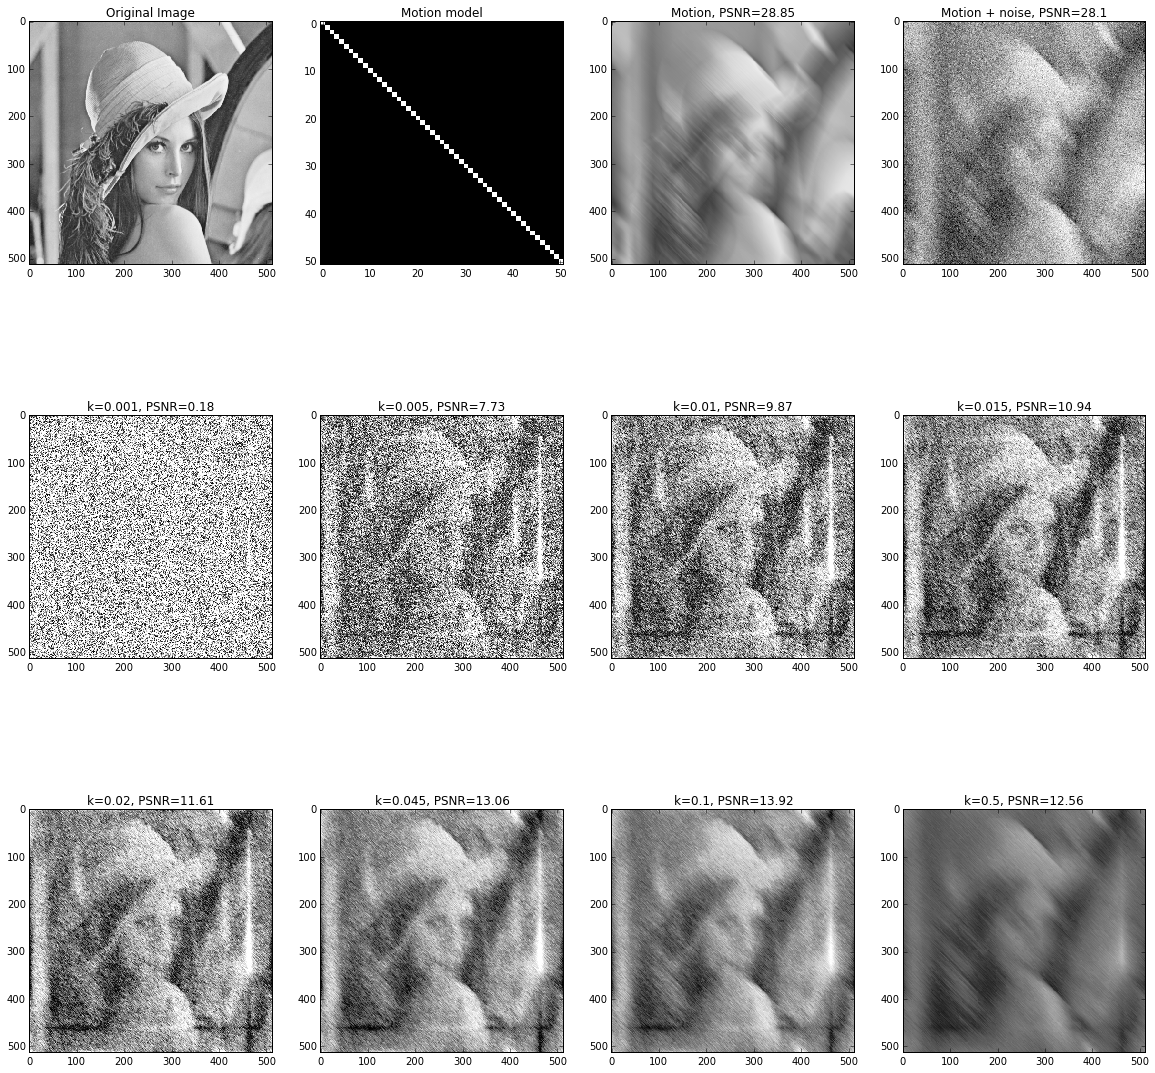

In [21]:
# plot all
fig, ax = plt.subplots(3,4)
fig.set_size_inches(20, 20)

ax[0,0].set_title('Original Image')
#ax[0,0].imshow(img[200:320,200:320], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
ax[0,0].imshow(img, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[0,1].set_title('Motion model')
ax[0,1].imshow(h, cmap=cm.Greys_r, interpolation="nearest")

ax[0,2].set_title('Motion, PSNR=' + str(psnr(img, m)))
#ax[0,2].imshow(m[200:320,200:320], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
ax[0,2].imshow(m, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[0,3].set_title('Motion + noise, PSNR=' + str(psnr(img, g)))
#ax[0,3].imshow(g[200:320,200:320], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
ax[0,3].imshow(g, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

for i in range(4):
    for j in range(2):
        p = i + 4*j
        ax[1+j,i].set_title('k='+ str(k[p]) + ', PSNR=' + str(psnr(img, f[p])))
        #ax[1+j,i].imshow(f[p][200:320,200:320], cmap=cm.Greys_r, interpolation="nearest")
        #ax[1+j,i].imshow(f[p][200:320,200:320], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
        ax[1+j,i].imshow(f[p], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")


### Wiener Filtering with SciPy
- Matlab's wiener2() removes Gaussian noise http://www.mathworks.com/help/images/ref/wiener2.html
- SciPy http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.wiener.html
- scikit http://scikit-image.org/docs/0.11.x/auto_examples/plot_restoration.html?highlight=wiener

PSNR after adding Gaussian noise: 21.6


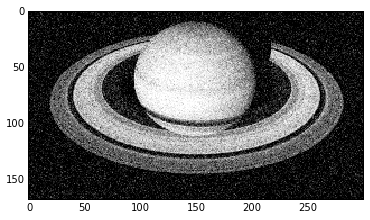

In [22]:
variance = 0.1 * 255

J = np.clip(I + np.random.normal(0, variance, I.shape).astype(np.int), 0, 255)

imgplt = plt.imshow(J, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
print 'PSNR after adding Gaussian noise:', psnr(I, J)

PSNR after Wiener filtering: 25.5


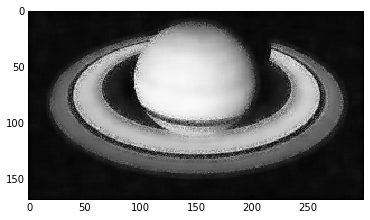

In [23]:
from scipy import signal as sgnl
K =  sgnl.wiener(J, mysize=(10,10))

imgplt = plt.imshow(K, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")
print 'PSNR after Wiener filtering:', psnr(I, K)

##Image registration
- http://www.mathworks.com/help/images/ref/imregister.html
- http://www.ri.cmu.edu/research_project_detail.html?project_id=515&menu_id=261
- http://en.wikipedia.org/wiki/Image_registration
- https://github.com/pyimreg/imreg

##JPEG quantization artefacts
Apply JPEG compression to an image, with high levels of compression such that the artifacts are noticeable. Can you apply any of the techniques learned so far to enhance the image, for example, reduce the artifacts or the blocking effects? Try as many techniques as you can and have time to do.

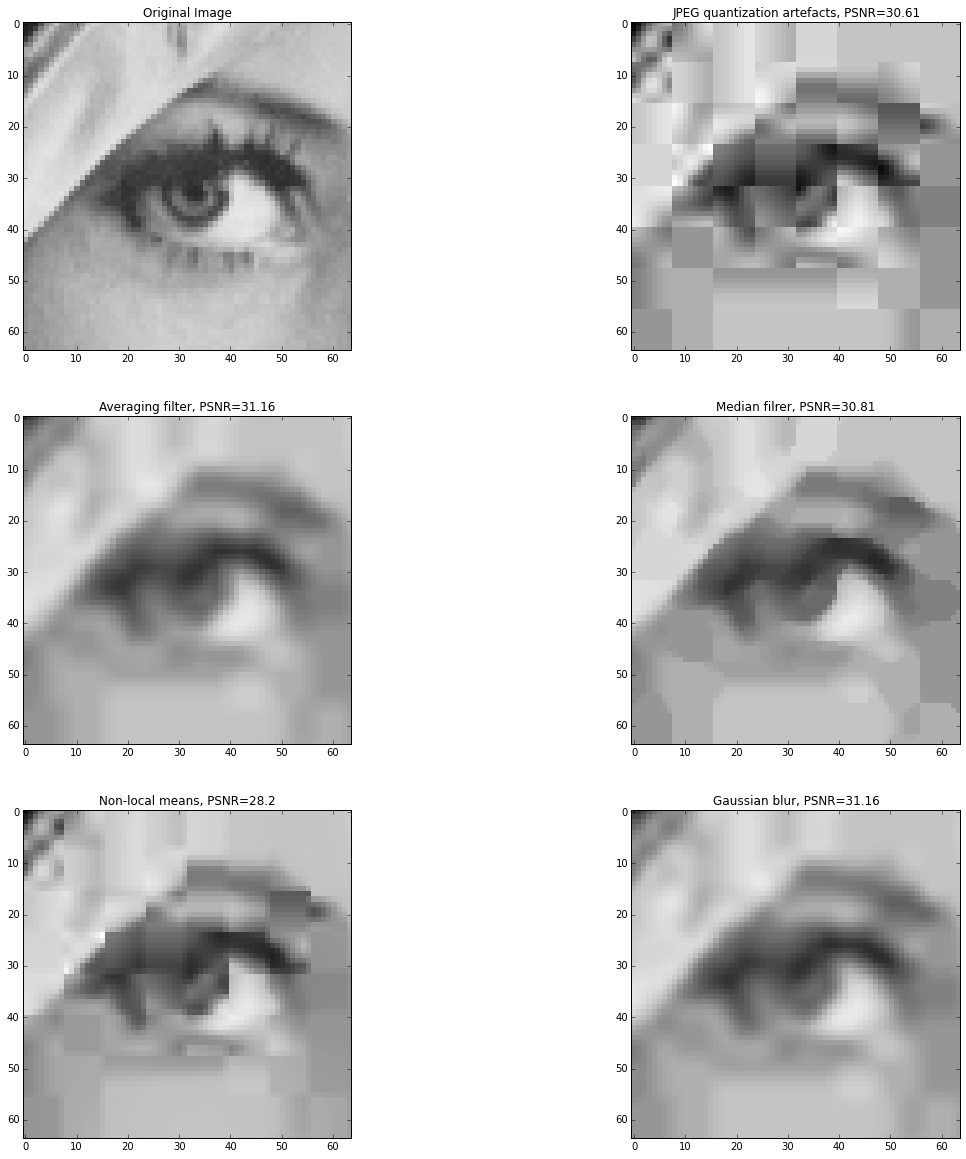

In [33]:
# Create image with low quality JPEG quantization artefacts from Lena original
img = cv2.imread('images/4.2.04.tiff', cv2.IMREAD_GRAYSCALE)

# write out low quality JPEG
cv2.imwrite('lena_compressed.jpg', img, [cv2.IMWRITE_JPEG_QUALITY , 5])

# read back
img_jpeg = cv2.imread('lena_compressed.jpg', cv2.IMREAD_UNCHANGED)  # cv2.IMREAD_UNCHANGE

# apply averaging filter
k = 5
kernel = np.ones((k,k))/(k*k)
img_jpeg_average = cv2.filter2D(img_jpeg, -1, kernel)

# apply median filer
k = 5
img_jpeg_median = cv2.medianBlur(img_jpeg, k)

# apply non-local means
from skimage.restoration import nl_means_denoising
k = 3
h = 0.05 * 255
img_jpeg_nl = nl_means_denoising(img_jpeg, patch_size=k, patch_distance=11, h=h, fast_mode=True)

# apply gaussian blur
k = 5
sigma = 2
img_jpeg_gaussian = cv2.GaussianBlur(img_jpeg, ksize=(k, k), sigmaX=sigma)


# plot all
fig, ax = plt.subplots(3,2)
fig.set_size_inches(20, 20)

ax[0,0].set_title('Original Image')
ax[0,0].imshow(img[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[0,1].set_title('JPEG quantization artefacts, PSNR=' + str(psnr(img,img_jpeg)))
ax[0,1].imshow(img_jpeg[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[1,0].set_title('Averaging filter, PSNR=' + str(psnr(img,img_jpeg_average)))
ax[1,0].imshow(img_jpeg_average[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[1,1].set_title('Median filrer, PSNR=' + str(psnr(img,img_jpeg_median)))
ax[1,1].imshow(img_jpeg_median[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[2,0].set_title('Non-local means, PSNR=' + str(psnr(img,img_jpeg_nl)))
ax[2,0].imshow(img_jpeg_nl[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

ax[2,1].set_title('Gaussian blur, PSNR=' + str(psnr(img,img_jpeg_gaussian)))
ax[2,1].imshow(img_jpeg_gaussian[232:296,232:296], cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

##Prediction Error Distribution
Apply any image predictor as those we learned in Week 2. Plot the histogram of the prediction error. Try to fit a function to it to learn what type of distribution best first the prediction error.

Using 3-cell top/left/top-left prediction.

MSE= 9.69742513873


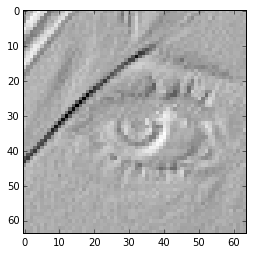

In [36]:
pred = np.full_like(img, 128, dtype=np.int)  # using average value. could also use np.mean(img).astype(np.int)

pred[:, 1:] = 2 * img[:, 0:-1].astype(np.int)
pred[1:, :] += 2 * img[0:-1, :].astype(np.int)
pred[1:, 1:] += img[0:-1, 0:-1].astype(np.int)
pred /= 5

error = img - pred
mse = np.sqrt(np.mean(np.square(error)))

print 'MSE=', mse

imgplt = plt.imshow(error[232:296,232:296], cmap=cm.Greys_r, interpolation="nearest")
#imgplt = plt.imshow(error[232:296,232:296], cmap=cm.Greys_r, vmin=-256, vmax=255, interpolation="nearest")
#imgplt = plt.imshow(error, cmap=cm.Greys_r, vmin=-256, vmax=255, interpolation="nearest")
#imgplt = plt.imshow(error, cmap=cm.Greys_r, interpolation="nearest")

Histogram

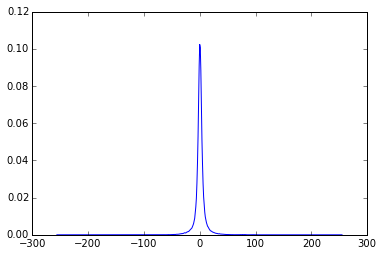

In [26]:
hist, bins = np.histogram(error, bins=512, range=(-256, 256), density=True)

imgplt = plt.plot(bins[:-1], hist)

Entropy

In [27]:
entropy = np.round(-np.sum(hist[hist > 0] * np.log2(hist[hist > 0])), 2)
print 'H =', entropy

H = 4.74


Better angle at histogram

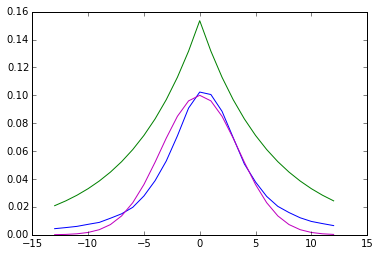

In [28]:
# Better angle
m =  np.max((np.max(error), np.abs(np.min(error))))
m = 12
r = 255 - m

# try to match with exponential PDF
a = 1.5 * np.max(hist)
c = 0  # -0.04 # add constant?
exp_pdf = a * np.exp(-a * np.abs(bins[:-1])) + c

# try to match with gaussian - fits better
s = 3.5
a = 0.1
gaussian = a * sgnl.gaussian(513, s)

bins.size
imgplt = plt.plot(bins[r:-r-1], hist[r:-r], 'b', bins[r:-r-1], exp_pdf[r:-r], 'g', bins[r:-r-1], gaussian[r:-r-1], 'm')